<a href="https://colab.research.google.com/github/binfalc/Machine-Learning/blob/master/Generating_Fashion_Designs_MINT_TensorF_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Import libraries

In [2]:
from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Conv2DTranspose
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import sys
import numpy as np

Using TensorFlow backend.


2. Set GAN class to generate new img data

In [10]:
class GAN():
  def __init__(self):
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 100

    optimizer = Adam(0.0002, 0.5)
    
    
    # Build and compile the discriminator
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss= 'binary_crossentropy',optimizer= optimizer, metrics= ['accuracy'])
    
    
    # Build the generator
    # The generator takes noise as input and generates imgs
    self.generator = self.build_generator()        
    z = Input(shape=(self.latent_dim,))
    img = self.generator(z)
    
    
    # Train only the generator
    self.discriminator.trainable = False
    
    
    # The discriminator takes generated images as input and determines validity
    validity = self.discriminator(img)
    
    
    # Combined model  (stacked generator and discriminator)
    # Trains the generator to fool the discriminator
    self.combined    = Model(z, validity)
    self.combined.compile(loss='binary_crossentropy',optimizer=optimizer)
    
    
  def build_generator(self):
    # Generator which uses MLP using simple dense layers activated by tanh
    model = Sequential()
   
    model.add(Dense(256, input_dim=self.latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(self.img_shape), activation='tanh'))
    model.add(Reshape(self.img_shape))
    
    model.summary()
    
    noise = Input(shape=(self.latent_dim,))
    img = model(noise)

    return Model(noise, img)
  
  
  def build_discriminator(self):
    
    model = Sequential()

    #Convolutional layers classify if image is real or fake 

    model.add(Conv2D(32, kernel_size=3, strides=2,input_shape=self.img_shape, padding="same")) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(Dropout(0.3)) 

    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same")) 
    model.add(ZeroPadding2D(padding=((0,1),(0,1)))) 
    model.add(BatchNormalization(momentum=0.82)) 
    model.add(LeakyReLU(alpha=0.25)) 
    model.add(Dropout(0.3)) 

    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same")) 
    model.add(BatchNormalization(momentum=0.82)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(Dropout(0.3)) 

    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same")) 
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.25)) 
    model.add(Dropout(0.3)) 

    #Building the output layer 
    model.add(Flatten()) 
    model.add(Dense(1, activation='sigmoid')) 
    

    model.summary()
    img = Input(shape=self.img_shape)
    validity = model(img)

    return Model(img, validity)
  
  
  def train(self, epochs, batch_size=128, sample_interval=100):
    # Load dataset
    (X_train, _), (_, _) = fashion_mnist.load_data()

    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------

      # Select a random batch of images
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      imgs = X_train[idx]

      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

      # Generate a batch of new images
      gen_imgs = self.generator.predict(noise)

      # Train the discriminator
      d_loss_real = self.discriminator.train_on_batch(imgs, valid)
      d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      # ---------------------
      #  Train Generator
      # ---------------------

      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

      # Train the generator (to have the discriminator label samples as valid)
      g_loss = self.combined.train_on_batch(noise, valid)

      # Plot the progress
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
      
      # If at save interval => save generated image samples
      if epoch % sample_interval == 0:
        self.sample_images(epoch)
        
  def sample_images(self, epoch):
      r, c = 2, 2
      noise = np.random.normal(0, 1, (r * c, self.latent_dim))
      gen_imgs = self.generator.predict(noise)
      
      # Rescale images 0 - 1
      gen_imgs = 0.5 * gen_imgs + 0.5

      fig, axs = plt.subplots(r, c)
      cnt = 0
      
      for i in range(r):
        for j in range(c):
          axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
          axs[i,j].axis('off')
          cnt += 1
          #fig.savefig("images/%d.png" % epoch)
      
      plt.show()
      plt.close()
      
      
  def display_images(self):
    r, c = 2, 2
    noise = np.random.normal(0, 1, (r * c, self.latent_dim))
    gen_imgs = self.generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    
    for i in range(r):
      for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        
    plt.show()
    plt.close()
    
      
print("GAN class ready")

GAN class ready


3. Instantiate the model and train

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 8, 8, 64)         

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.158951, acc.: 30.47%] [G loss: 0.548275]


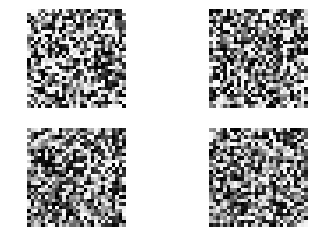

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.742246, acc.: 64.06%] [G loss: 0.769761]
2 [D loss: 0.676575, acc.: 60.16%] [G loss: 0.994133]
3 [D loss: 0.452672, acc.: 78.12%] [G loss: 1.322246]
4 [D loss: 0.407817, acc.: 84.38%] [G loss: 1.904831]
5 [D loss: 0.295560, acc.: 91.41%] [G loss: 1.889175]
6 [D loss: 0.271410, acc.: 89.84%] [G loss: 1.988743]
7 [D loss: 0.236734, acc.: 93.75%] [G loss: 2.383205]
8 [D loss: 0.225950, acc.: 92.19%] [G loss: 2.516034]
9 [D loss: 0.143732, acc.: 99.22%] [G loss: 2.793658]
10 [D loss: 0.169621, acc.: 95.31%] [G loss: 2.578854]
11 [D loss: 0.146623, acc.: 92.97%] [G loss: 2.913210]
12 [D loss: 0.136978, acc.: 96.88%] [G loss: 3.093421]
13 [D loss: 0.106468, acc.: 96.88%] [G loss: 2.916116]
14 [D loss: 0.115404, acc.: 98.44%] [G loss: 3.359766]
15 [D loss: 0.080812, acc.: 99.22%] [G loss: 3.565392]
16 [D loss: 0.116607, acc.: 96.09%] [G loss: 3.678676]
17 [D loss: 0.065071, acc.: 100.00%] [G loss: 3.438306]
18 [D loss: 0.050447, acc.: 99.22%] [G loss: 3.423666]
19 [D loss: 0.1027

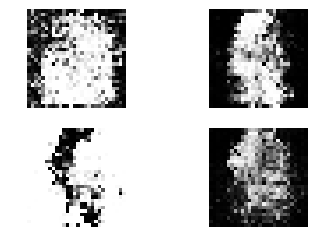

201 [D loss: 0.169104, acc.: 95.31%] [G loss: 4.764157]
202 [D loss: 0.163611, acc.: 91.41%] [G loss: 4.289959]
203 [D loss: 0.419644, acc.: 79.69%] [G loss: 6.345400]
204 [D loss: 0.305969, acc.: 87.50%] [G loss: 6.548073]
205 [D loss: 0.268604, acc.: 88.28%] [G loss: 2.990802]
206 [D loss: 0.114052, acc.: 95.31%] [G loss: 2.848386]
207 [D loss: 0.047693, acc.: 99.22%] [G loss: 3.994492]
208 [D loss: 0.131548, acc.: 98.44%] [G loss: 4.107082]
209 [D loss: 0.257108, acc.: 92.97%] [G loss: 3.089709]
210 [D loss: 0.178308, acc.: 95.31%] [G loss: 4.554794]
211 [D loss: 0.182707, acc.: 94.53%] [G loss: 4.684157]
212 [D loss: 0.501482, acc.: 75.00%] [G loss: 2.407049]
213 [D loss: 0.679082, acc.: 71.09%] [G loss: 4.244748]
214 [D loss: 0.410343, acc.: 81.25%] [G loss: 6.578401]
215 [D loss: 0.130801, acc.: 96.09%] [G loss: 4.080845]
216 [D loss: 0.440888, acc.: 82.03%] [G loss: 4.689813]
217 [D loss: 0.347870, acc.: 86.72%] [G loss: 4.473792]
218 [D loss: 0.468217, acc.: 77.34%] [G loss: 5.

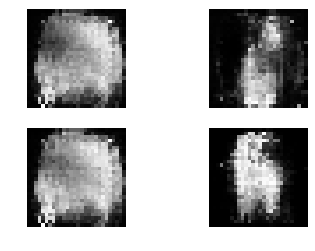

401 [D loss: 0.865353, acc.: 50.00%] [G loss: 1.062697]
402 [D loss: 0.850246, acc.: 43.75%] [G loss: 1.046363]
403 [D loss: 0.866869, acc.: 49.22%] [G loss: 1.320995]
404 [D loss: 0.839596, acc.: 50.78%] [G loss: 1.162884]
405 [D loss: 0.744088, acc.: 56.25%] [G loss: 1.178836]
406 [D loss: 0.843090, acc.: 49.22%] [G loss: 1.088879]
407 [D loss: 0.803717, acc.: 46.09%] [G loss: 1.071377]
408 [D loss: 0.893619, acc.: 43.75%] [G loss: 1.042694]
409 [D loss: 0.801105, acc.: 55.47%] [G loss: 1.100475]
410 [D loss: 0.774656, acc.: 54.69%] [G loss: 1.117124]
411 [D loss: 0.706364, acc.: 58.59%] [G loss: 1.171815]
412 [D loss: 0.756805, acc.: 54.69%] [G loss: 1.040929]
413 [D loss: 0.705918, acc.: 60.16%] [G loss: 1.255907]
414 [D loss: 0.756108, acc.: 53.12%] [G loss: 1.198051]
415 [D loss: 0.794685, acc.: 54.69%] [G loss: 1.303640]
416 [D loss: 0.720554, acc.: 61.72%] [G loss: 1.070502]
417 [D loss: 0.919306, acc.: 38.28%] [G loss: 1.104163]
418 [D loss: 0.697890, acc.: 59.38%] [G loss: 1.

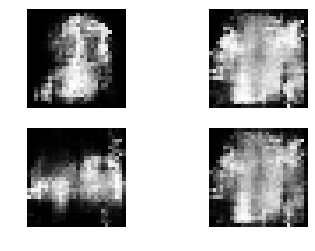

601 [D loss: 0.629706, acc.: 62.50%] [G loss: 1.121051]
602 [D loss: 0.569572, acc.: 72.66%] [G loss: 1.244502]
603 [D loss: 0.634576, acc.: 64.84%] [G loss: 1.190880]
604 [D loss: 0.583651, acc.: 73.44%] [G loss: 1.210701]
605 [D loss: 0.623448, acc.: 64.06%] [G loss: 1.214681]
606 [D loss: 0.621002, acc.: 64.84%] [G loss: 1.189737]
607 [D loss: 0.704787, acc.: 57.81%] [G loss: 1.256303]
608 [D loss: 0.660241, acc.: 61.72%] [G loss: 1.296281]
609 [D loss: 0.638197, acc.: 67.97%] [G loss: 1.149189]
610 [D loss: 0.621157, acc.: 63.28%] [G loss: 1.253141]
611 [D loss: 0.585584, acc.: 72.66%] [G loss: 1.326102]
612 [D loss: 0.577244, acc.: 69.53%] [G loss: 1.326422]
613 [D loss: 0.638137, acc.: 64.84%] [G loss: 1.151871]
614 [D loss: 0.618675, acc.: 63.28%] [G loss: 1.191009]
615 [D loss: 0.615264, acc.: 63.28%] [G loss: 1.335361]
616 [D loss: 0.754555, acc.: 55.47%] [G loss: 1.175283]
617 [D loss: 0.692929, acc.: 61.72%] [G loss: 1.298295]
618 [D loss: 0.585794, acc.: 67.19%] [G loss: 1.

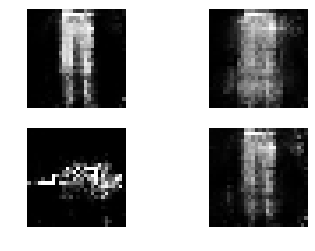

801 [D loss: 0.599330, acc.: 67.97%] [G loss: 1.197429]
802 [D loss: 0.613299, acc.: 65.62%] [G loss: 1.178764]
803 [D loss: 0.653764, acc.: 62.50%] [G loss: 1.244977]
804 [D loss: 0.688426, acc.: 63.28%] [G loss: 1.191068]
805 [D loss: 0.645787, acc.: 60.16%] [G loss: 1.246326]
806 [D loss: 0.589571, acc.: 69.53%] [G loss: 1.133091]
807 [D loss: 0.758184, acc.: 51.56%] [G loss: 1.026775]
808 [D loss: 0.602952, acc.: 70.31%] [G loss: 1.195928]
809 [D loss: 0.532731, acc.: 71.88%] [G loss: 1.411891]
810 [D loss: 0.635456, acc.: 64.84%] [G loss: 1.225356]
811 [D loss: 0.658521, acc.: 66.41%] [G loss: 1.074965]
812 [D loss: 0.723226, acc.: 53.91%] [G loss: 1.035853]
813 [D loss: 0.706983, acc.: 53.12%] [G loss: 1.073171]
814 [D loss: 0.573654, acc.: 67.19%] [G loss: 1.093699]
815 [D loss: 0.575058, acc.: 71.09%] [G loss: 1.098052]
816 [D loss: 0.688902, acc.: 58.59%] [G loss: 1.273840]
817 [D loss: 0.560788, acc.: 72.66%] [G loss: 1.293817]
818 [D loss: 0.652243, acc.: 58.59%] [G loss: 1.

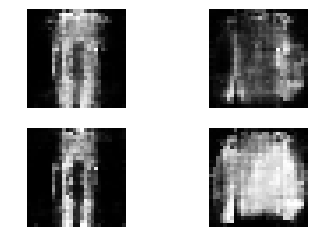

1001 [D loss: 0.609113, acc.: 64.84%] [G loss: 1.320131]
1002 [D loss: 0.625061, acc.: 69.53%] [G loss: 1.165577]
1003 [D loss: 0.503384, acc.: 76.56%] [G loss: 1.394464]
1004 [D loss: 0.749826, acc.: 51.56%] [G loss: 1.046646]
1005 [D loss: 0.675357, acc.: 61.72%] [G loss: 1.104733]
1006 [D loss: 0.616276, acc.: 67.19%] [G loss: 1.135302]
1007 [D loss: 0.604747, acc.: 75.00%] [G loss: 1.163333]
1008 [D loss: 0.638543, acc.: 64.84%] [G loss: 1.331692]
1009 [D loss: 0.646219, acc.: 71.09%] [G loss: 1.161296]
1010 [D loss: 0.651284, acc.: 67.19%] [G loss: 1.223021]
1011 [D loss: 0.604590, acc.: 70.31%] [G loss: 1.038900]
1012 [D loss: 0.658267, acc.: 58.59%] [G loss: 0.901746]
1013 [D loss: 0.653601, acc.: 66.41%] [G loss: 1.100198]
1014 [D loss: 0.663727, acc.: 60.94%] [G loss: 1.132928]
1015 [D loss: 0.563820, acc.: 71.88%] [G loss: 1.178967]
1016 [D loss: 0.652869, acc.: 64.84%] [G loss: 1.205187]
1017 [D loss: 0.588399, acc.: 69.53%] [G loss: 1.191125]
1018 [D loss: 0.638019, acc.: 6

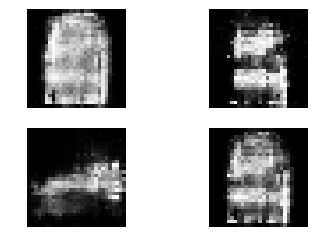

1201 [D loss: 0.760124, acc.: 53.12%] [G loss: 1.206291]
1202 [D loss: 0.812247, acc.: 47.66%] [G loss: 1.105674]
1203 [D loss: 0.653834, acc.: 64.06%] [G loss: 1.083362]
1204 [D loss: 0.797084, acc.: 51.56%] [G loss: 1.132054]
1205 [D loss: 0.706953, acc.: 53.91%] [G loss: 1.179269]
1206 [D loss: 0.739481, acc.: 53.12%] [G loss: 1.127080]
1207 [D loss: 0.583696, acc.: 71.09%] [G loss: 1.171083]
1208 [D loss: 0.742423, acc.: 59.38%] [G loss: 1.299119]
1209 [D loss: 0.768505, acc.: 50.00%] [G loss: 1.254951]
1210 [D loss: 0.640507, acc.: 63.28%] [G loss: 1.217950]
1211 [D loss: 0.706559, acc.: 57.81%] [G loss: 0.972909]
1212 [D loss: 0.684901, acc.: 55.47%] [G loss: 1.184033]
1213 [D loss: 0.641921, acc.: 60.94%] [G loss: 1.272783]
1214 [D loss: 0.551016, acc.: 72.66%] [G loss: 1.419903]
1215 [D loss: 0.645160, acc.: 61.72%] [G loss: 1.124054]
1216 [D loss: 0.749708, acc.: 53.91%] [G loss: 1.070603]
1217 [D loss: 0.631181, acc.: 64.06%] [G loss: 1.104020]
1218 [D loss: 0.671904, acc.: 5

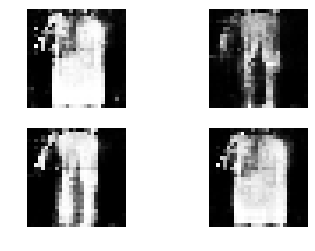

1401 [D loss: 0.680616, acc.: 64.06%] [G loss: 1.201793]
1402 [D loss: 0.637718, acc.: 66.41%] [G loss: 1.385336]
1403 [D loss: 0.466644, acc.: 78.12%] [G loss: 1.226111]
1404 [D loss: 0.442177, acc.: 78.12%] [G loss: 1.446514]
1405 [D loss: 0.568137, acc.: 70.31%] [G loss: 1.255162]
1406 [D loss: 0.676367, acc.: 55.47%] [G loss: 1.327034]
1407 [D loss: 0.540489, acc.: 71.09%] [G loss: 1.248008]
1408 [D loss: 0.561346, acc.: 68.75%] [G loss: 1.380336]
1409 [D loss: 0.490916, acc.: 75.78%] [G loss: 1.561137]
1410 [D loss: 0.535629, acc.: 71.88%] [G loss: 1.113528]
1411 [D loss: 0.531546, acc.: 76.56%] [G loss: 1.479695]
1412 [D loss: 0.520019, acc.: 75.00%] [G loss: 1.317644]
1413 [D loss: 0.661196, acc.: 63.28%] [G loss: 1.220383]
1414 [D loss: 0.591483, acc.: 67.97%] [G loss: 1.305456]
1415 [D loss: 0.588581, acc.: 67.97%] [G loss: 1.503970]
1416 [D loss: 0.669765, acc.: 64.84%] [G loss: 1.500951]
1417 [D loss: 0.553006, acc.: 70.31%] [G loss: 1.260306]
1418 [D loss: 0.468231, acc.: 8

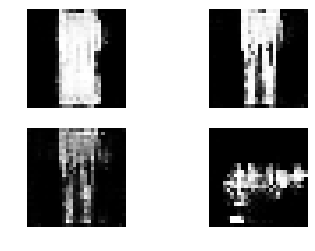

1601 [D loss: 0.486121, acc.: 78.91%] [G loss: 1.709370]
1602 [D loss: 0.539724, acc.: 71.88%] [G loss: 1.465371]
1603 [D loss: 0.688380, acc.: 61.72%] [G loss: 1.474113]
1604 [D loss: 0.609520, acc.: 66.41%] [G loss: 1.443843]
1605 [D loss: 0.581048, acc.: 68.75%] [G loss: 1.551907]
1606 [D loss: 0.534968, acc.: 73.44%] [G loss: 1.815946]
1607 [D loss: 0.478052, acc.: 75.00%] [G loss: 1.684237]
1608 [D loss: 0.493478, acc.: 78.91%] [G loss: 1.681241]
1609 [D loss: 0.478874, acc.: 75.00%] [G loss: 1.788436]
1610 [D loss: 0.530559, acc.: 73.44%] [G loss: 1.926466]
1611 [D loss: 0.522706, acc.: 73.44%] [G loss: 1.967382]
1612 [D loss: 0.451879, acc.: 81.25%] [G loss: 1.658058]
1613 [D loss: 0.393626, acc.: 87.50%] [G loss: 1.828860]
1614 [D loss: 0.526466, acc.: 68.75%] [G loss: 1.777240]
1615 [D loss: 0.556263, acc.: 71.09%] [G loss: 1.470672]
1616 [D loss: 0.554583, acc.: 68.75%] [G loss: 1.605238]
1617 [D loss: 0.505358, acc.: 80.47%] [G loss: 1.529003]
1618 [D loss: 0.517179, acc.: 7

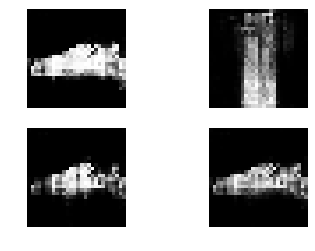

1801 [D loss: 0.339973, acc.: 85.94%] [G loss: 1.993806]
1802 [D loss: 0.368234, acc.: 87.50%] [G loss: 1.955067]
1803 [D loss: 0.481711, acc.: 75.78%] [G loss: 1.893265]
1804 [D loss: 0.396539, acc.: 85.16%] [G loss: 1.915067]
1805 [D loss: 0.393958, acc.: 79.69%] [G loss: 2.732754]
1806 [D loss: 0.457560, acc.: 78.91%] [G loss: 2.193533]
1807 [D loss: 0.437637, acc.: 80.47%] [G loss: 2.094045]
1808 [D loss: 0.441063, acc.: 80.47%] [G loss: 1.528289]
1809 [D loss: 0.307540, acc.: 92.97%] [G loss: 2.293107]
1810 [D loss: 0.394098, acc.: 82.03%] [G loss: 1.712465]
1811 [D loss: 0.448894, acc.: 81.25%] [G loss: 1.724411]
1812 [D loss: 0.563310, acc.: 71.88%] [G loss: 2.093207]
1813 [D loss: 0.375220, acc.: 86.72%] [G loss: 1.914882]
1814 [D loss: 0.382580, acc.: 80.47%] [G loss: 1.861709]
1815 [D loss: 0.325777, acc.: 89.06%] [G loss: 1.819752]
1816 [D loss: 0.391885, acc.: 82.03%] [G loss: 2.190392]
1817 [D loss: 0.269965, acc.: 92.19%] [G loss: 2.491538]
1818 [D loss: 0.386907, acc.: 8

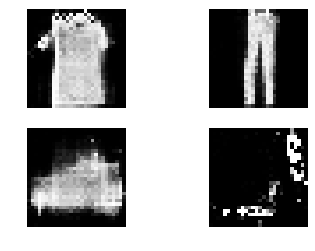

2001 [D loss: 0.399977, acc.: 81.25%] [G loss: 2.210371]
2002 [D loss: 0.431429, acc.: 84.38%] [G loss: 2.438901]
2003 [D loss: 0.363132, acc.: 84.38%] [G loss: 2.861477]
2004 [D loss: 0.511832, acc.: 71.88%] [G loss: 1.876980]
2005 [D loss: 0.256691, acc.: 91.41%] [G loss: 2.509870]
2006 [D loss: 0.345521, acc.: 85.94%] [G loss: 2.424525]
2007 [D loss: 0.273229, acc.: 92.19%] [G loss: 2.405157]
2008 [D loss: 0.402123, acc.: 82.03%] [G loss: 2.614964]
2009 [D loss: 0.507685, acc.: 71.88%] [G loss: 2.208469]
2010 [D loss: 0.303650, acc.: 88.28%] [G loss: 2.573444]
2011 [D loss: 0.394307, acc.: 80.47%] [G loss: 2.151282]
2012 [D loss: 0.412346, acc.: 80.47%] [G loss: 2.293602]
2013 [D loss: 0.520835, acc.: 75.00%] [G loss: 2.227199]
2014 [D loss: 0.588893, acc.: 72.66%] [G loss: 2.332266]
2015 [D loss: 0.295586, acc.: 89.06%] [G loss: 2.109906]
2016 [D loss: 0.355009, acc.: 85.94%] [G loss: 2.563273]
2017 [D loss: 0.333006, acc.: 85.16%] [G loss: 2.442919]
2018 [D loss: 0.271424, acc.: 9

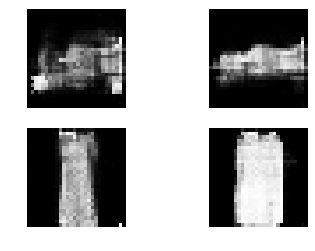

2201 [D loss: 0.183445, acc.: 96.88%] [G loss: 3.464334]
2202 [D loss: 0.180841, acc.: 95.31%] [G loss: 3.518002]
2203 [D loss: 0.143972, acc.: 96.88%] [G loss: 2.948936]
2204 [D loss: 0.261257, acc.: 92.19%] [G loss: 2.234870]
2205 [D loss: 0.183150, acc.: 96.09%] [G loss: 3.337085]
2206 [D loss: 0.145035, acc.: 96.09%] [G loss: 3.171955]
2207 [D loss: 0.198698, acc.: 92.19%] [G loss: 2.901264]
2208 [D loss: 0.280022, acc.: 92.19%] [G loss: 2.358534]
2209 [D loss: 0.312397, acc.: 85.94%] [G loss: 3.750428]
2210 [D loss: 0.168922, acc.: 91.41%] [G loss: 4.621256]
2211 [D loss: 0.260650, acc.: 89.06%] [G loss: 2.545217]
2212 [D loss: 0.281090, acc.: 89.06%] [G loss: 3.120008]
2213 [D loss: 0.230634, acc.: 93.75%] [G loss: 3.362214]
2214 [D loss: 0.183759, acc.: 92.19%] [G loss: 3.622223]
2215 [D loss: 0.155510, acc.: 95.31%] [G loss: 3.834161]
2216 [D loss: 0.263110, acc.: 88.28%] [G loss: 2.995965]
2217 [D loss: 0.220701, acc.: 93.75%] [G loss: 2.863663]
2218 [D loss: 0.201585, acc.: 9

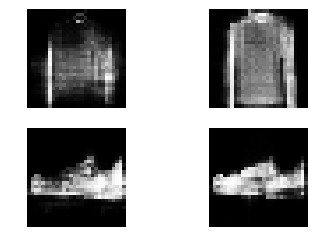

2401 [D loss: 0.220714, acc.: 92.19%] [G loss: 2.703197]
2402 [D loss: 0.436030, acc.: 77.34%] [G loss: 3.491084]
2403 [D loss: 0.128245, acc.: 96.09%] [G loss: 4.324683]
2404 [D loss: 0.139378, acc.: 96.09%] [G loss: 3.308409]
2405 [D loss: 0.210637, acc.: 93.75%] [G loss: 2.449614]
2406 [D loss: 0.086667, acc.: 100.00%] [G loss: 2.945202]
2407 [D loss: 0.159946, acc.: 97.66%] [G loss: 3.267115]
2408 [D loss: 0.136703, acc.: 98.44%] [G loss: 3.996694]
2409 [D loss: 0.240976, acc.: 91.41%] [G loss: 3.396852]
2410 [D loss: 0.249637, acc.: 89.06%] [G loss: 2.933299]
2411 [D loss: 0.165816, acc.: 96.88%] [G loss: 3.662744]
2412 [D loss: 0.092614, acc.: 97.66%] [G loss: 3.645867]
2413 [D loss: 0.209492, acc.: 93.75%] [G loss: 3.395105]
2414 [D loss: 0.213899, acc.: 94.53%] [G loss: 3.044750]
2415 [D loss: 0.258654, acc.: 91.41%] [G loss: 2.595890]
2416 [D loss: 0.251433, acc.: 92.19%] [G loss: 2.564511]
2417 [D loss: 0.078264, acc.: 100.00%] [G loss: 3.891484]
2418 [D loss: 0.211568, acc.:

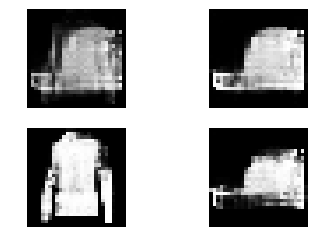

2601 [D loss: 0.133036, acc.: 98.44%] [G loss: 2.524253]
2602 [D loss: 0.305648, acc.: 89.84%] [G loss: 3.542742]
2603 [D loss: 0.169464, acc.: 94.53%] [G loss: 4.238519]
2604 [D loss: 0.265005, acc.: 91.41%] [G loss: 3.222354]
2605 [D loss: 0.134834, acc.: 96.09%] [G loss: 3.313393]
2606 [D loss: 0.071484, acc.: 100.00%] [G loss: 3.295576]
2607 [D loss: 0.079898, acc.: 100.00%] [G loss: 3.297022]
2608 [D loss: 0.229946, acc.: 92.19%] [G loss: 1.953554]
2609 [D loss: 0.171132, acc.: 94.53%] [G loss: 3.954743]
2610 [D loss: 0.098889, acc.: 99.22%] [G loss: 4.050236]
2611 [D loss: 0.219789, acc.: 91.41%] [G loss: 2.855084]
2612 [D loss: 0.220443, acc.: 92.97%] [G loss: 2.580837]
2613 [D loss: 0.121179, acc.: 97.66%] [G loss: 3.409761]
2614 [D loss: 0.074854, acc.: 99.22%] [G loss: 3.151506]
2615 [D loss: 0.197138, acc.: 95.31%] [G loss: 2.173040]
2616 [D loss: 0.265857, acc.: 89.84%] [G loss: 3.626877]
2617 [D loss: 0.085270, acc.: 98.44%] [G loss: 5.126124]
2618 [D loss: 0.185572, acc.:

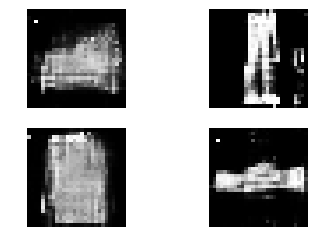

2801 [D loss: 0.149613, acc.: 95.31%] [G loss: 2.716488]
2802 [D loss: 0.128091, acc.: 98.44%] [G loss: 4.271926]
2803 [D loss: 0.201074, acc.: 91.41%] [G loss: 4.176083]
2804 [D loss: 0.101027, acc.: 97.66%] [G loss: 3.605402]
2805 [D loss: 0.179714, acc.: 95.31%] [G loss: 3.970986]
2806 [D loss: 0.077427, acc.: 99.22%] [G loss: 4.564687]
2807 [D loss: 0.218237, acc.: 91.41%] [G loss: 2.703386]
2808 [D loss: 0.264690, acc.: 88.28%] [G loss: 3.789742]
2809 [D loss: 0.110277, acc.: 97.66%] [G loss: 5.421618]
2810 [D loss: 0.085868, acc.: 99.22%] [G loss: 3.901992]
2811 [D loss: 0.118711, acc.: 95.31%] [G loss: 3.319324]
2812 [D loss: 0.114236, acc.: 96.09%] [G loss: 3.820379]
2813 [D loss: 0.051706, acc.: 100.00%] [G loss: 5.153327]
2814 [D loss: 0.190402, acc.: 94.53%] [G loss: 3.646075]
2815 [D loss: 0.124103, acc.: 96.09%] [G loss: 3.668698]
2816 [D loss: 0.183521, acc.: 94.53%] [G loss: 4.262743]
2817 [D loss: 0.088804, acc.: 96.88%] [G loss: 3.607400]
2818 [D loss: 0.328087, acc.: 

In [12]:
gan = GAN()
gan.train(epochs=3000, batch_size=64, sample_interval=200)

4. Generate new designs

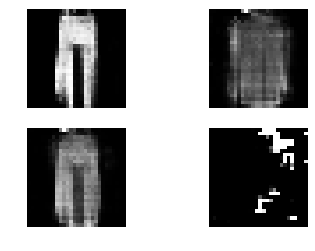

In [17]:
# show example_1 generate image
gan.display_images()

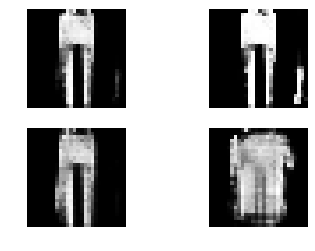

In [18]:
# show example_2 generate image
gan.display_images()